In [1]:

%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys
import os

if ".." not in sys.path:
    sys.path.append("..")

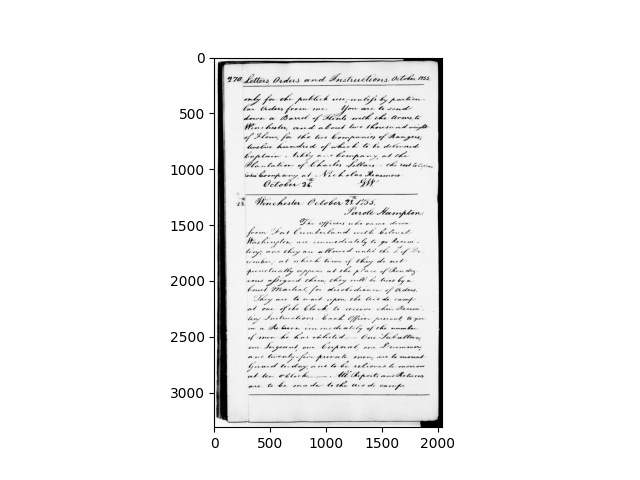

In [2]:
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

image = "2700270"
imagePath = f"./gw/pages/{image}.png"
gtPath = f"./gw/ground_truth/{image}.gtp"
hgtPath = f"./gw/heuristic_ground_truth/{image}.gtp"

imageFile = Image.open(imagePath)

# Für später folgende Verarbeitungsschritte muss das Bild mit float32-Werten vorliegen.
im_arr = np.asarray(imageFile)
doc_height , doc_width = im_arr.shape
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(im_arr, cmap=cm.get_cmap('Greys_r'))


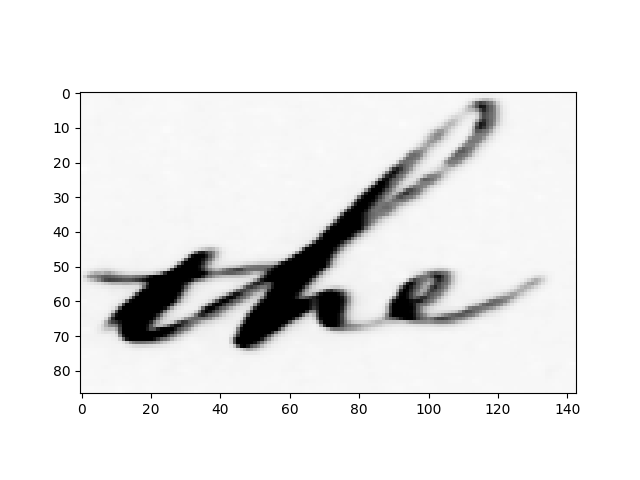

In [3]:
# load test image
labels = open(gtPath ,"r")
wordTheLine = labels.read().split("\n")[9].split(" ")
y1 , x1 , y2 , x2 = int(wordTheLine[0]) , int(wordTheLine[1]) , int(wordTheLine[2]) , int(wordTheLine[3])
testing_word_arr = im_arr[x1:x2, y1:y2]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(testing_word_arr, cmap=cm.get_cmap('Greys_r'))

In [4]:
# compute the features of the test image 
from scipy.cluster.vq import kmeans2
from common.features import compute_sift_descriptors

testing_word_frames ,testing_word_desc  = compute_sift_descriptors(testing_word_arr)
page_frames ,page_desc  = compute_sift_descriptors(im_arr)
n_centroids = 100 
# create a cluster of the full image
_, labels = kmeans2(page_desc, n_centroids, iter=20, minit='points')

/home/amr/.local/lib/python3.8/site-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


<BarContainer object of 100 artists>

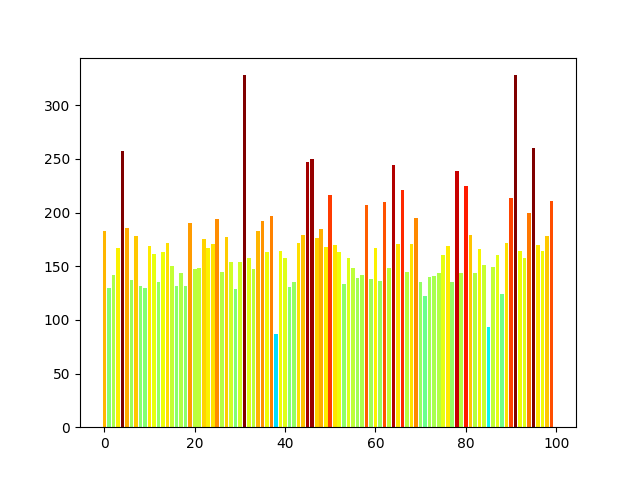

In [5]:
# compute the bag of features
bin_count = np.bincount(labels,minlength = n_centroids)
bin_count

fig = plt.figure()
ax = fig.add_subplot(111)
colormap = cm.get_cmap('jet')
ax.bar(list(range(n_centroids)) , bin_count , color = [colormap(bin) for bin in bin_count])

sift_descriptors shape (16932, 128)
page_frames shape 16932
labels shape (16932,)
x1=319, x2=406, y1=580, y2=723
{87: 1, 49: 1, 30: 1, 62: 1, 58: 1, 22: 2, 42: 1, 80: 1, 73: 1, 23: 1, 36: 1, 57: 1, 12: 1, 45: 3, 59: 2, 35: 1, 31: 1, 90: 1, 86: 1, 53: 1, 91: 1, 81: 2, 34: 1}


<BarContainer object of 23 artists>

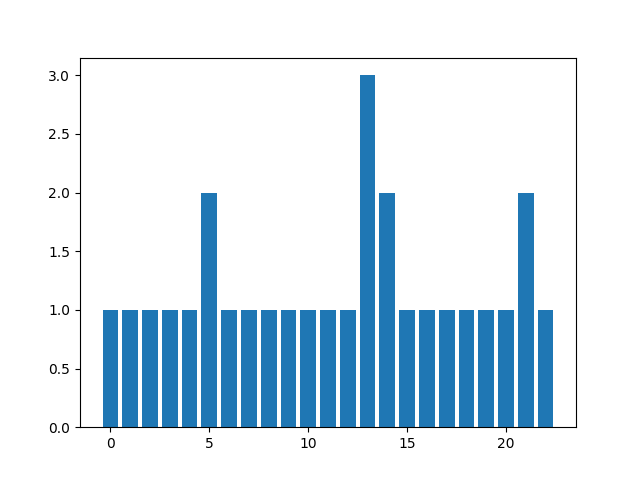

In [6]:
# takes a position of a grid in the image and uses the cluster of sift desc to calculate the bag of features histgramm
def get_bag_of_words_histogram(sift_descriptors , page_frames , labels , x1 , x2 , y1 , y2):
	# sift_descriptors: the sift descriptors of the full image
	# sift_descriptors_positions: the positions of the sift descriptors in the full image
	# sift_descriptors_labels_array: an array that contains a label for each sift descriptors
	# x1,x2,y1,y2: the positions of the frame

	# the function works as follows:
		# go over all descriptors inside the frame
		# for each one of them get its label
		# increment a counter for each label
		# return the histogram
		# the histogram is a map of this form {'label' : count} e.g {'f1' : 4} means that the label f1 is coming 4 times inside the frame
	assert sift_descriptors.shape[0] == len(page_frames) and len(page_frames) == labels.shape[0] , "wrong vars"
	print(f"x1={x1}, x2={x2}, y1={y1}, y2={y2}")

	label_to_count = {}
	for desc , frame , label in zip(sift_descriptors , page_frames , labels):
		if frame[1] < x1 or frame[1] > x2 or frame[0] < y1 or frame[0]  > y2:
			continue
		label_to_count[label] = label_to_count.get(label , 0) + 1
	return label_to_count


# # bag of features histogram for the request image
request_image_histogram = get_bag_of_words_histogram(page_desc , page_frames , labels , x1 , x2 , y1 , y2)

print(request_image_histogram)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(request_image_histogram)), list(request_image_histogram.values()), align='center')


In [22]:

# # bag of features histograms for the frames 
frame_width = x2 - x1
frame_height = y2 - y1
step_size_x = frame_width // 2
step_size_y = frame_height // 2
frame_x1 = 0
frame_y1 = 0
frame_x2 = frame_x1 + frame_width
frame_y2 = frame_y1 + frame_height

In [23]:

window_histograms = [] # array of dicts {"window" : [x1,y1,x2,y2] , "histogram" : ...}

while True:
	print("compute histogram for window x1,y1,x2,y2" ,frame_x1 , frame_y1 , frame_x2 , frame_y2 )
	# do operation on the window
	window_histogram = get_bag_of_words_histogram(page_desc , page_frames , labels , frame_x1 , frame_x2 , frame_y1 , frame_y2)
	window_histograms.append({"window" : [frame_x1 , frame_y1 , frame_x2 , frame_y2] , "histogram" : window_histogram})

	# update the window to the left
	frame_x1 += step_size_x
	frame_x2 = frame_x1 + frame_width

	# if we are at the end to the most far right. go down 
	if frame_x2 > doc_width: 
		frame_x1 = 0
		frame_x2 = frame_x1 + frame_width
		frame_y1 += step_size_y
		frame_y2 = frame_y1 + frame_height
	
	# if we are done. break
	if frame_y2 > doc_height:
		break


compute histogram for window x1,y1,x2,y2 0 0 87 143
sift_descriptors shape (16932, 128)
page_frames shape 16932
labels shape (16932,)
x1=0, x2=87, y1=0, y2=143
compute histogram for window x1,y1,x2,y2 43 0 130 143
sift_descriptors shape (16932, 128)
page_frames shape 16932
labels shape (16932,)
x1=43, x2=130, y1=0, y2=143
compute histogram for window x1,y1,x2,y2 86 0 173 143
sift_descriptors shape (16932, 128)
page_frames shape 16932
labels shape (16932,)
x1=86, x2=173, y1=0, y2=143
compute histogram for window x1,y1,x2,y2 129 0 216 143
sift_descriptors shape (16932, 128)
page_frames shape 16932
labels shape (16932,)
x1=129, x2=216, y1=0, y2=143
compute histogram for window x1,y1,x2,y2 172 0 259 143
sift_descriptors shape (16932, 128)
page_frames shape 16932
labels shape (16932,)
x1=172, x2=259, y1=0, y2=143
compute histogram for window x1,y1,x2,y2 215 0 302 143
sift_descriptors shape (16932, 128)
page_frames shape 16932
labels shape (16932,)
x1=215, x2=302, y1=0, y2=143
compute histog

In [24]:
# compare for each window the difference in the two histograms
def compare_histograms(hist1 , hist2): 
	result = {}
	for i in range(n_centroids):
		label = i 
		labelCountFromHist1 = hist1.get(label , 0)
		labelCountFromHist2 = hist2.get(label , 0)
		result[label] = abs(labelCountFromHist1 - labelCountFromHist2)
	return result

window_histograms_after_comparing_with_request_image_histogram = []
for wh in window_histograms:
	window = wh['window']
	histogram = wh['histogram']
	window_histograms_after_comparing_with_request_image_histogram.append({'window' : window , 'histogram' : compare_histograms(request_image_histogram , histogram)})


In [25]:
window_histograms_after_comparing_with_request_image_histogram

def compare(hist):
	return sum(hist['histogram'].values())


# sort window_histograms_after_comparing_with_request_image_histogram based on the sum of all keys
window_histograms_after_comparing_with_request_image_histogram.sort(key=compare)


{'window': [301, 568, 388, 711], 'histogram': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 0, 19: 0, 20: 0, 21: 1, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 1, 32: 0, 33: 0, 34: 0, 35: 1, 36: 0, 37: 1, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 1, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 1, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 1, 58: 0, 59: 0, 60: 0, 61: 0, 62: 1, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 1, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 1, 77: 0, 78: 0, 79: 1, 80: 1, 81: 1, 82: 1, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 1, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0}}
87
143


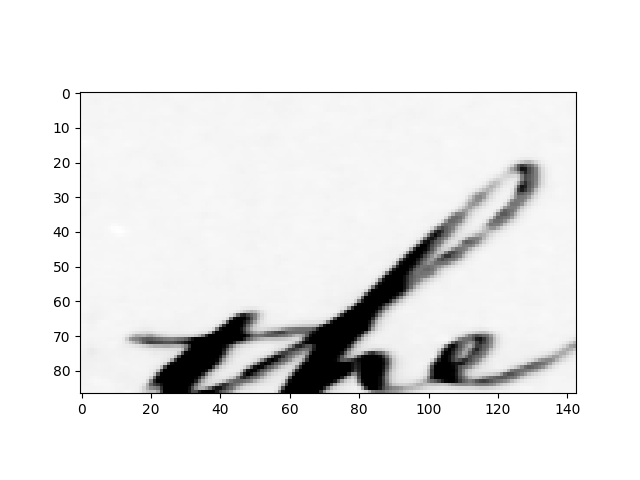

In [27]:

print(window_histograms_after_comparing_with_request_image_histogram[0])

wx1,wy1,wx2,wy2 = window_histograms_after_comparing_with_request_image_histogram[0]['window']

print(wx2 - wx1)
print(wy2 - wy1)

testing_word_arr = im_arr[wx1:wx2, wy1:wy2]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(testing_word_arr, cmap=cm.get_cmap('Greys_r'))